**ISYA 2024, Solar Physics**

# Anatomy of a sunspot


#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended python imports to solve the exercises.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8))  # Larger figure sizes
plt.rc('image', origin='lower')    # Make image zero on bottom

## 1. Background

### 1.1 La Palma

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Swedish_Solar_Telescope.jpg/321px-Swedish_Solar_Telescope.jpg" alt="SST">

Atop the volcano in the island of La Palma (Canary Islands) sits the [Roque de Los Muchachos Observatory](https://en.wikipedia.org/wiki/Roque_de_los_Muchachos_Observatory),  one of the world's largest astronomical observatories. Among others, it hosts the largest single aperture optical telescope in the world ([GranTeCan](https://en.wikipedia.org/wiki/Gran_Telescopio_Canarias)), the [Nordic Optical Telescope](https://en.wikipedia.org/wiki/Nordic_Optical_Telescope) and the [Swedish 1-m Solar Telescope](https://en.wikipedia.org/wiki/Swedish_Solar_Telescope) (SST). The SST has a modest size compared to night-time optical telescopes, but it compensates with highly advanced instrumentation that enable it to consistently observe at its diffraction limit with a truly astronomical data rate (Gigabytes per second). While not the largest solar telescope around, the SST is arguably still the most prolific solar observatory and has produced the most detailed views into the solar atmosphere.

In this project, you will make use of detailed spectral observations from the SST to solve an age-old mystery that is still not completely understood: what is a sunspot and what are its properties? You will follow the steps of early astronomers who asked this question, starting with [George Ellery Hale](https://en.wikipedia.org/wiki/George_Ellery_Hale), who first linked sunspots and magnetic fields in 1908. You will do it in an accelerated fashion, because unlike early astronomers you will not be limited by low-resolution instruments. Instead, you will make use of rich SST observations whose level of detail would be unthinkable just a few decades ago. But first, let's recap how we can use spectra to get information about the atmosphere of a star.

### 1.2 Spectral Diagnostics

In this exercise, we will work from an observational perspective: we will use observed spectra to determine the parameters of the solar atmosphere in a sunspot.

#### 1.2.1 Velocities

Stellar atmospheres are moving. Individual atoms and electrons are moving on a microscopic scale because of their temperature, and the atmosphere as a whole can have macroscopic velocities. Radiation from a moving body is going to be shifted according to the Doppler effect:

\begin{equation}
\frac{\lambda_0 -  \lambda}{\lambda_0} = \frac{\Delta\lambda}{\lambda_0} = \frac{v}{c},
\end{equation}

where $\lambda_0$ is the rest wavelength, $\lambda$ the observed Doppler-shifted wavelength, and $v$ the velocity of the body. Spectral lines are also Doppler shifted, and this is one of their most powerful uses: their $\Delta\lambda$ shifts can be used to measure the velocities of distant bodies according to equation (1). Using this definition, a positive $v$ means a blue-shift (meaning the body is moving towards us), and a negative $v$ means a red-shift (moving away from us). The only catch is that velocities measured from the Doppler effect are not the full velocity vector, but only the component in the axis towards the observer (line of sight), so they are:

$$
v_\mathrm{los} = v \cos\theta,
$$

where $\cos\theta\equiv\mu$, and $\theta$ the angle between the line of sight and the normal of the emitting surface.

#### 1.2.2 Line widths

The widths of spectral lines are another powerful diagnostic tool. Several different factors can affect the widths or broadening of lines, with the natural broadening and Doppler broadening among the most important. However, in sunspots the widths of spectral lines are dominated by the [Zeeman effect](https://en.wikipedia.org/wiki/Zeeman_effect). For magnetically-sensitive lines, the presence of magnetic fields will split the atomic level energies. This split causes one spectral line to become instead two (or more) lines, and their separation $\Delta\lambda_B$ is given by:

\begin{equation}
\Delta\lambda_B = \frac{e}{4\pi m_e c} \lambda_0^2 B.
\end{equation}

(The above is valid for mksA SI units.)

Typical line properties and magnetic fields in the sun mean that the Zeeman components of a line are not fully split. Instead of appearing as two separated lines, a spectral line appears as one broad line.


#### 1.2.3 Magnetic Fields

For lines that are not fully split by Zeeman effect, we cannot use the intensity profile to directly measure magnetic fields. The observations we will use here fall into this category. However, if we observe not only the intensity $I_\lambda$ but also $V_\lambda$, the circular polarisation of light (also called Stokes V), and are in the regime of the so-called *Weak Field Approximation*, we have that 

\begin{equation}
V_\lambda = - \Delta\lambda_B \bar{g} \cos\theta \frac{\partial I_\lambda}{\partial \lambda},
\end{equation}

where $\theta$ is the angle between the line of sight and the magnetic field vector, and $\bar{g}$ the effective Landé factor, a measure of how magnetically-sensitive a line is. Thus, knowing $I_\lambda$ and $V_\lambda$ we can use the two equations above to determine $B\cos\theta$, or $B_\mathrm{los}$, the line of sight component of the magnetic field vector. 

Equation (3) is valid for any wavelength, but in practice not all wavelengths have the same sensivity due to instrumental effects such as noise. Therefore, the following formulation is usually adopted to measure $B_\mathrm{los}$ from observations:

\begin{equation}
B_\mathrm{los} = -\frac{4 \pi m_e c}{e \bar{g} \lambda_0^2}\frac{\sum_\lambda \frac{\partial I}{\partial \lambda} V_\lambda}{\sum_\lambda\left(\frac{\partial I}{\partial \lambda}\right)^2}
\end{equation}


**Note:** strictly speaking, sunspots are not in the regime of the Weak Field Approximation, which is valid when $\Delta\lambda_B \ll \Delta\lambda_D$ . However, for the sake of simplicity, you should assume it is valid here.


### 1.3 An SST Dataset

#### 1.3.1 Overview

We will work with a dataset acquired with the [CRISP](https://dubshen.astro.su.se/wiki/index.php/CRISP) instrument at the SST. CRISP is a Fabry-Pérot interferometer that acquires images at different wavelengths, and can quickly "scan" through spectral lines. These datasets are multi dimensional: there are two dimensions of space (x and y), a dimension of wavelength (e.g. number of points in a spectral line), and a dimension of time. In addition, there can be a fifth dimension: different types of polarisation (reconstructing the [Stokes vector](https://en.wikipedia.org/wiki/Stokes_parameters)). For this exercise we use a single timestep, so there is no time dimension. 

We will use only one spectral line, the Fe I line at 617.334 nm. This line has a lower-level energy of 0.35568 aJ, and an effective Landé factor $\bar{g}$ of 2.499. This line is widely used in studies of solar magnetism, and most famously it was the [line chosen for the HMI instrument](https://arxiv.org/pdf/astro-ph/0608124.pdf) on board [SDO](https://sdo.gsfc.nasa.gov/mission/).

This dataset is state of the art; its spatial resolution is one of the highest available today. It was acquired on the 7th of August 2020. The target was the central sunspot of [NOAA Active Region 12770](https://solarmonitor.org/index.php?date=20200807&region=12770). The data were reduced by and are provided courtesy of Jayant Joshi and Luc Rouppe van der Voort (University of Oslo).

Before you can work with it, you must [dowload the dataset](https://www.uio.no/studier/emner/matnat/astro/AST4310/h20/data/sst_sunspot_617_2020.08.07.fits) (93 MB). The format is a special type of FITS file that can be loaded into an astropy QTable, a type of table with units. You can open it with:

In [2]:
# Assuming you have downloaded the file into the current directory:
DATA_FILE = 'SST_sunspot_617_2020.08.07.fits' 

data = QTable.read(DATA_FILE)
data

intensity,stokes_v,wavelength
W / (Hz sr m2),W / (Hz sr m2),nm
"float32[961,974]","float32[961,974]",float64
3.81328142395887e-08 .. 3.623370403715853e-08,-3.2918050230090756e-11 .. 1.8876449014992858e-10,617.268
3.768163381323575e-08 .. 3.59759475543342e-08,-1.327763853725683e-11 .. -3.162058948014135e-10,617.276
3.667330616963227e-08 .. 3.392468883589572e-08,-7.741495638979856e-11 .. -9.938728312564038e-11,617.284
3.548280247400726e-08 .. 2.985078495498783e-08,-8.753564539887293e-11 .. -3.744499710300886e-10,617.288
3.0823972707594294e-08 .. 2.4031239220789757e-08,-1.4693181393798938e-10 .. -5.6474065007749985e-11,617.292
2.3560883022355483e-08 .. 2.1409466199884264e-08,-6.235768845730405e-12 .. -3.969632348527208e-12,617.296
2.199313975381756e-08 .. 2.410669708297064e-08,-8.666208722862834e-11 .. -3.1688598967072323e-10,617.3
2.8138451568793243e-08 .. 2.8830916320998767e-08,-1.517680286999834e-10 .. -3.0086358404624036e-10,617.304


It has three variables: intensity, Stokes V (circular polarisation), and wavelength. There are 13 wavelengths, roughly covering the Fe I 617 nm line profile. The intensity has three dimensions: (wavelength, ny, nx). With `ny=961` and `nx=974`, the dataset contains almost one million spectra. The size of each spatial pixel is approximately 0.058 arcseconds, or 42.46 km on the solar surface. We can plot an image at the first wavelength point (far wings of the line, close to continuum) with:

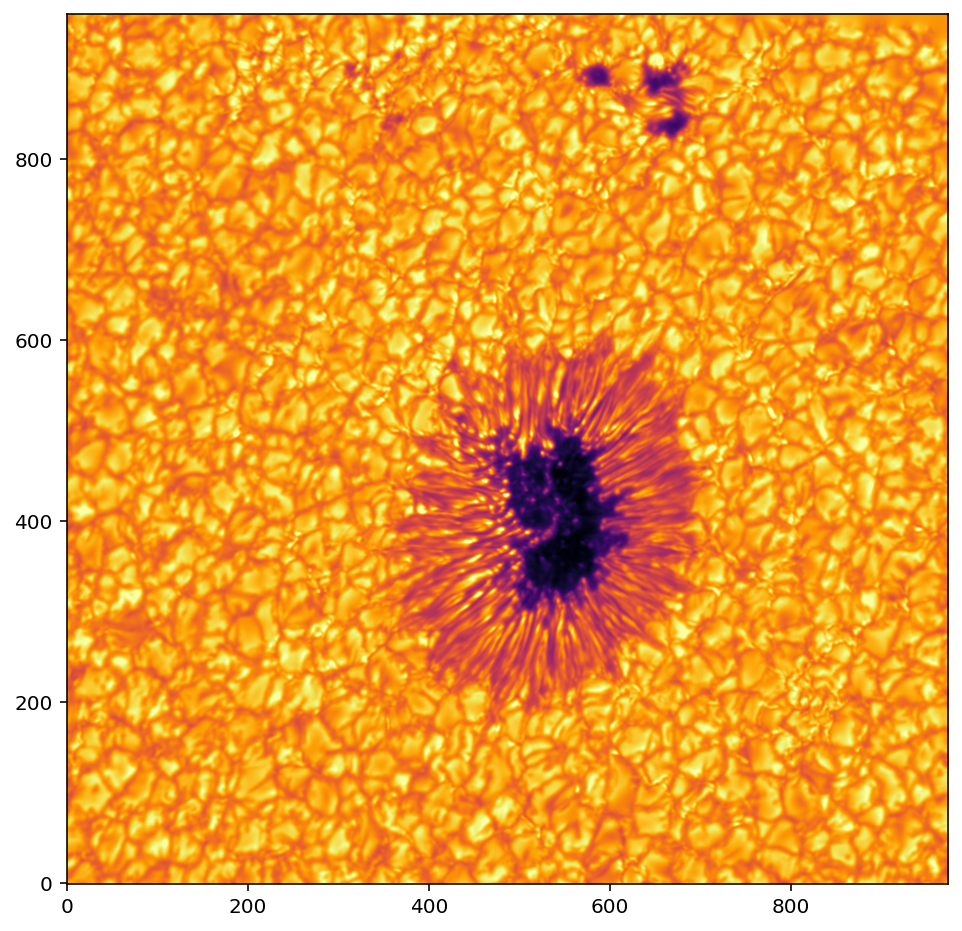

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno');

We can see the solar granulation pattern, a sign of the the bubbling convection, and a much darker sunspot in the middle. A sunspot has two regions: the dark **umbra**, and the surrounding **penumbra**. In a sunspot the surface convection is inhibited, and therefore it is significantly cooler and darker because not as much radiation is transported to the surface. Near the top of the image there are a few dark spots. They are not sunspots, but pores. They are nearly as dark as the umbra, but show no penumbra. 

We can also see an image of Stokes V. Here at a wavelength with maximum polarisation, it is very different from the intensity:

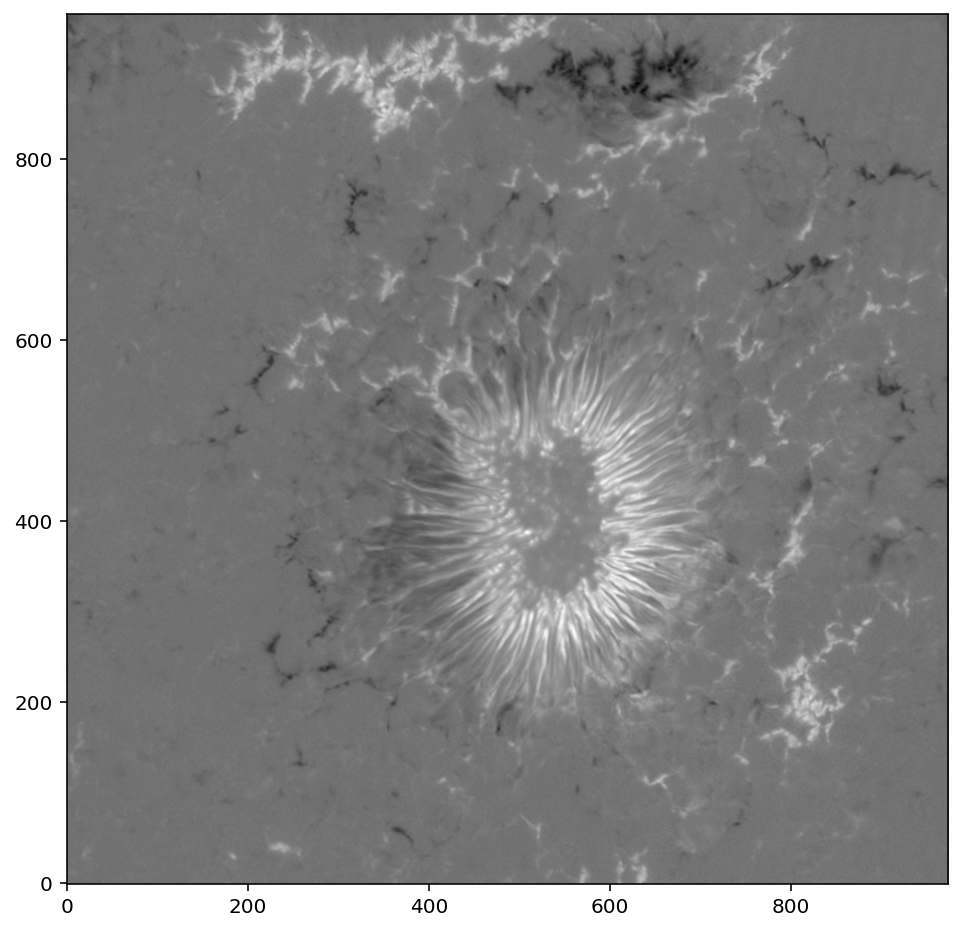

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(data['stokes_v'][4].value,  cmap='gist_gray');

We can also plot individual spectra at specific (x, y) points, for example in the granulation and in the sunspot's umbra:

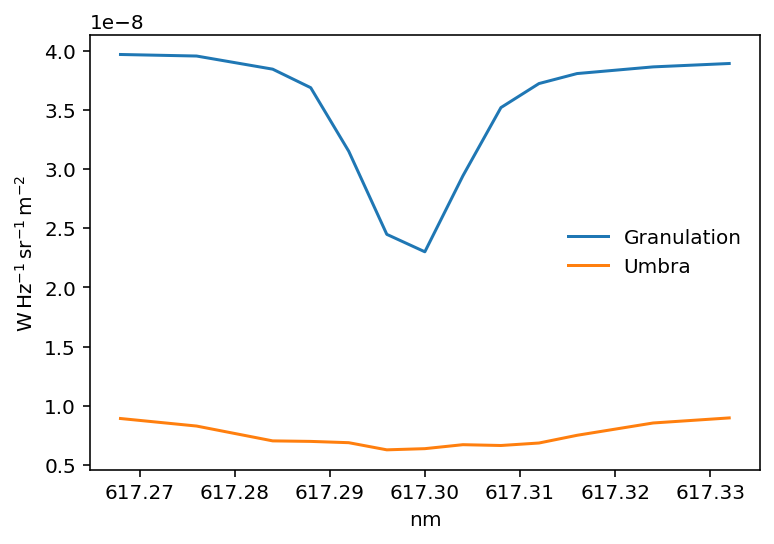

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
wavelength = data['wavelength']
ax.plot(wavelength, data['intensity'][:, 200, 200], label='Granulation')
ax.plot(wavelength, data['intensity'][:, 400, 550], label='Umbra')
ax.legend();

You can see that the spectral resolution is relatively coarse: for the sake of fast cadence, the line was only observed at 13 wavelengths.

#### 1.3.2 Data Analysis in Practice

**Line properties.** To measure properties such as velocities and widths of a line, one option is to fit a function (e.g. a Gaussian is often approximate enough). Since this line is in absorption, you would have to fit an inverted Gaussian, which is cumbersome and numerically unstable. Much better is to instead invert the profiles:

$$
I_\mathrm{inv} = I_0 - I_\lambda,
$$
where $I_0$ is the continuum intensity (e.g. the first or last wavelength).

When we approximate the spectra by a Gaussian, the velocity shift is how much the Gaussian in shifted in the wavelength axis. In other words, it is $\mu$, the mean of the distribution. Similarly, the width of the line, which can also be defined as the Full Width at Half Maximum (FWHM) can be related to $\sigma$, the standard deviation of the Gaussian: FWHM$=2\sqrt{2\ln 2}\sigma$.

If you look carefully at individual spectra, you will see that many have a shape that is not very Gaussian. Still, it is ok to fit a Gaussian: the point here is to get a statistical sense, and not a perfect fit every time (with one million spectra, you can't really afford to do that). Besides, even if the line is not Gaussian, the fit would still give you a rough measurement of the Gaussian velocity shift and width.

Other than fitting a function, a simpler option that is also robust in the statistical sense is to take the moments of the distribution (in this case, of the spectra). The first moment $E[X]$ is the mean $\mu$ (i.e., velocity shift), and the second moment $E[(X-\mu)^2]$ is the variance ($\sigma^2$). To take the moments from spectra you need to normalise them, so the expressions become:

\begin{eqnarray}
E[X] = & \mu = &\frac{\int \lambda I_\lambda \mathrm{d}\lambda}{\int I_\lambda \mathrm{d}\lambda} \\
E[(X-\mu)^2] = & \sigma^2 = &\frac{\int (\lambda -\mu)^2 I_\lambda \mathrm{d}\lambda}{\int I_\lambda \mathrm{d}\lambda}.
\end{eqnarray}

Note that you also need to invert the profiles to take the moments in this way.

**Image analysis.** When dealing with rich images showing a lot of information, it is often burdensome to compare images side by side. A powerful technique, useful when the images have exactly the same field of view, is to *blink* them, letting your eyes highlight similarities and differences. You can do this with `matplotlib.animation` and the HTML display in Jupyter. For example, to blink between the continuum intensity and the Stokes V image shown earlier:

In [8]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
im1 = ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno')
im2 = ax.imshow(data['stokes_v'][4].value,  cmap='gist_gray')

anim = ArtistAnimation(fig, [[im1], [im2]], interval=600, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

Press the play button to start playing the blinking sequence. If you want to add multiple maps (e.g. velocity shift, width, etc.), you just add more image figures and combine them inside `ArtistAnimation`.

# Exercises

##### 1. Make a plot of the following: individual intensity spectra in the sunspot umbra, penumbra, and outside the sunspot. Plot also the mean spectrum (averaged over the whole field of view)


  

In [9]:
# Your code here

##### 2. Do the same as before, but now for Stokes V

In [9]:
# Your code here

##### 3. Plot a spectrogram (image where wavelength is in x axis, position in y axis) of Stokes V that cuts across the sunspot.

In [9]:
# Your code here

##### 4. Using the first and second moments of intensity, plot an estimate of the line of sight velocities and spectral widths across the field of view

In [9]:
# Your code here

##### 5. Using the weak field approximation, calculate and plot the line of sight magnetic field (in mT) across the field of view

In [9]:
# Your code here